# Building ARIMA Models

These are the typical steps to fitting ARIMA models to time series data

1. plotting the data
2. possibly transforming the data
3. identifying the dependence orders of the model
4. parameter estimation
5. diagnostics
6. model choice


In [1]:
8import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#import os
#os.chdir("C:\\Users\\Aram\\Documents\\Work\\AUA\\Time Series Forecasting\\Slides\\Lecture 7\\")

## Dataset

The data contains the number of total passengers every month, from January 1949 to December 1960. The numbers in the dataset refer to the amount in thousands. This dataset was originally used by Box and Jenkins in their work in 1976.

In [11]:
Passengers = pd.read_csv(r'AirPassengers.csv') # Air Passengers
Passengers.head()

,index,value
0,1949 Jan,112
1,1949 Feb,118
2,1949 Mar,132
3,1949 Apr,129
4,1949 May,121


### Index column to date format
https://www.w3schools.com/python/python_datetime.asp

In [12]:
from datetime import datetime

Passengers.index = pd.to_datetime(Passengers['index'],format="%Y %b") # 
del Passengers["index"]
Passengers.head()

,value
index,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


## ARIMA

**Definition:** A process $x_{t}$ is said to be $\mathbf{A} \mathbf{R} \mathbf{I M A}(p, d, q)$ if

$$
\nabla^{d} x_{t}=(1-B)^{d} x_{t}
$$

is ARMA(p, q). In general, we will write the model as

$$
\phi(B)(1-B)^{d} x_{t}=\theta(B) w_{t}
$$

If $\mathrm{E}\left(\nabla^{d} x_{t}\right)=\mu,$ we write the model as

$$
\phi(B)(1-B)^{d} x_{t}=\delta+\theta(B) w_{t}
$$
where $\delta=\mu\left(1-\phi_{1}-\cdots-\phi_{p}\right)$

## 1. plotting the data

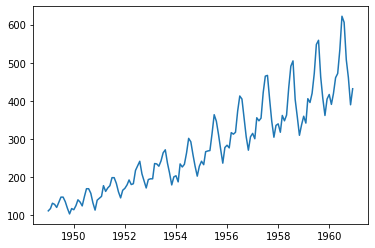

In [13]:
plt.plot(Passengers.index,Passengers.value)         # plot series
plt.show();

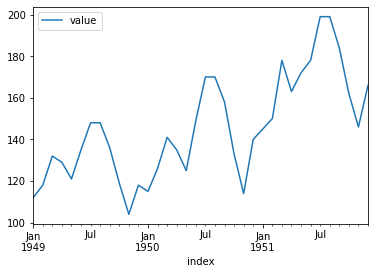

In [14]:
Passengers.iloc[0:36].plot(y= "value")
plt.show();

## 2. possibly transforming the data

It has both seasonality and trend. Would differencing help?

### First order differencing

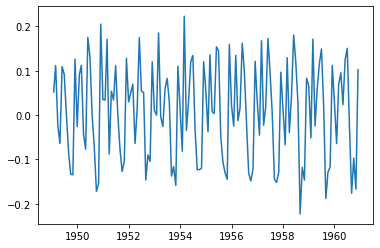

In [15]:
Passengers['value'] = np.log(Passengers['value'])           # log of values
Passengers['valued1'] = Passengers['value'].diff()            # Take first difference
Passengersd1 = Passengers.drop(Passengers.index[0])               # Remove first observation
plt.plot(Passengersd1.index,Passengersd1.valued1)         # plot series
plt.show();

### Seasonal Differencing (periods = 12)

In [16]:
Passengers

,value,valued1
index,,
1949-01-01,4.718499,NaN
1949-02-01,4.770685,0.052186
1949-03-01,4.882802,0.112117
1949-04-01,4.859812,-0.022990
1949-05-01,4.795791,-0.064022
...,...,...
1960-08-01,6.406880,-0.026060
1960-09-01,6.230481,-0.176399
1960-10-01,6.133398,-0.097083


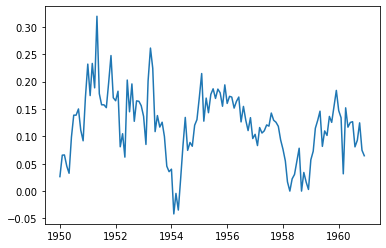

In [17]:
Passengers['valued12'] = Passengers['value'].diff(12)            # Seasonal differencing periods = 12
Passengersd12 = Passengers.drop(Passengers.index[0:12])          # Remove first observations
#Passengersd12.head(20)
plt.plot(Passengersd12.index,Passengersd12.valued12)             # plot series
plt.show();

### Seasonal Differencing of first order differenced data (periods = 12)

In [18]:
Passengers

,value,valued1,valued12
index,,,
1949-01-01,4.718499,NaN,NaN
1949-02-01,4.770685,0.052186,NaN
1949-03-01,4.882802,0.112117,NaN
1949-04-01,4.859812,-0.022990,NaN
1949-05-01,4.795791,-0.064022,NaN
...,...,...,...
1960-08-01,6.406880,-0.026060,0.080731
1960-09-01,6.230481,-0.176399,0.092754
1960-10-01,6.133398,-0.097083,0.124585


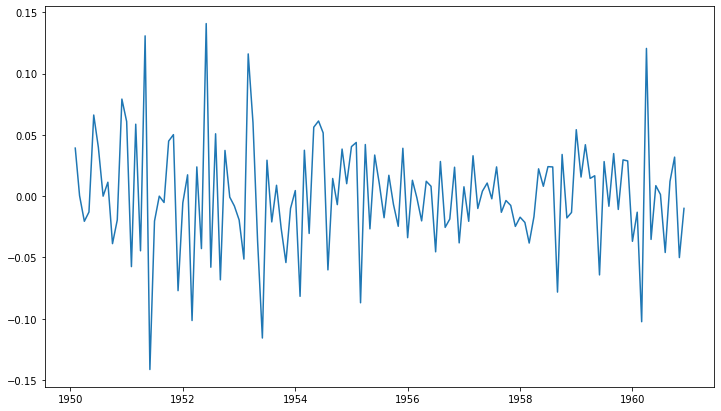

In [19]:
Passengers['valued12d1'] = Passengers['valued1'].diff(12)            # Seasonal differencing periods = 12
Passengersd12 = Passengers.drop(Passengers.index[0:12])              # Remove first observations
#Passengersd12.head(20)
plt.figure(figsize=(12,7))
plt.plot(Passengersd12.index,Passengersd12.valued12d1)               # plot series
plt.show();

### Higher orders of differencing

In [20]:
Passengers['diff_o1'] = np.append([np.nan] * 1, np.diff(Passengers['value'], n=1))
Passengers['diff_o2'] = np.append([np.nan] * 2, np.diff(Passengers['value'], n=2))
Passengers['diff_o3'] = np.append([np.nan] * 3, np.diff(Passengers['value'], n=3))
Passengers.head()

,value,valued1,valued12,valued12d1,diff_o1,diff_o2,diff_o3
index,,,,,,,
1949-01-01,4.718499,NaN,NaN,NaN,NaN,NaN,NaN
1949-02-01,4.770685,0.052186,NaN,NaN,0.052186,NaN,NaN
1949-03-01,4.882802,0.112117,NaN,NaN,0.112117,0.059932,NaN
1949-04-01,4.859812,-0.022990,NaN,NaN,-0.022990,-0.135107,-0.195038
1949-05-01,4.795791,-0.064022,NaN,NaN,-0.064022,-0.041032,0.094074


In [21]:
Passengers.tail()

,value,valued1,valued12,valued12d1,diff_o1,diff_o2,diff_o3
index,,,,,,,
1960-08-01,6.406880,-0.026060,0.080731,-0.045934,-0.026060,-0.176733,-0.202119
1960-09-01,6.230481,-0.176399,0.092754,0.012024,-0.176399,-0.150338,0.026395
1960-10-01,6.133398,-0.097083,0.124585,0.031830,-0.097083,0.079315,0.229654
1960-11-01,5.966147,-0.167251,0.074503,-0.050082,-0.167251,-0.070168,-0.149483
1960-12-01,6.068426,0.102279,0.064539,-0.009964,0.102279,0.269530,0.339698


### Second order of differencing

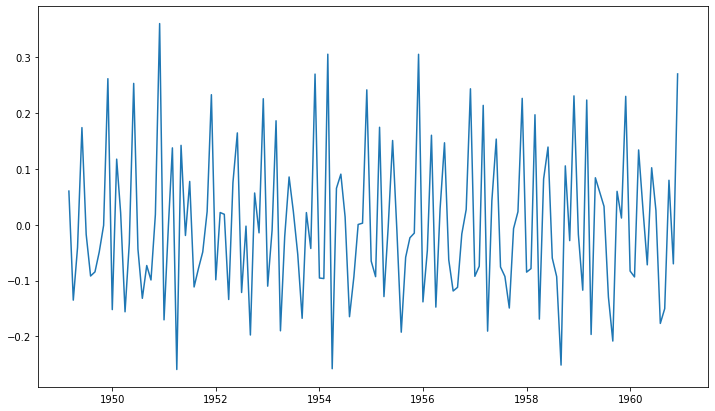

In [22]:
Passengersd_o2 = Passengers.drop(Passengers.index[0:2])          # Remove first observation
#Passengersd12.head(20)
plt.figure(figsize=(12,7))
plt.plot(Passengersd_o2.index,Passengersd_o2.diff_o2)             # plot series
plt.show();

### Third order of differencing

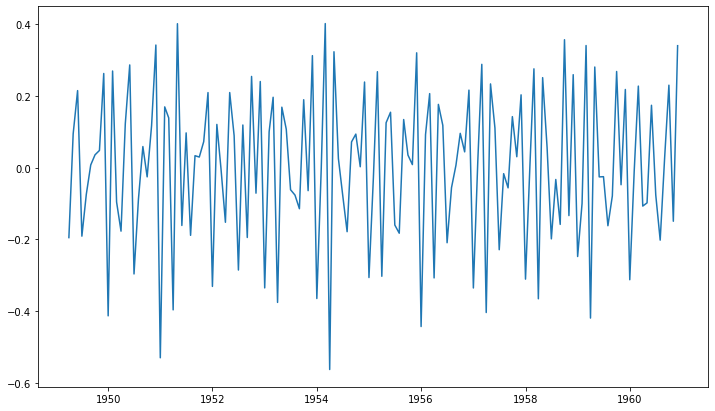

In [23]:
Passengersd_o3 = Passengers.drop(Passengers.index[0:3])          # Remove first observation
#Passengersd12.head(20)
plt.figure(figsize=(12,7))
plt.plot(Passengersd_o3.index,Passengersd_o3.diff_o3)             # plot series
plt.show();

## 3. identifying the dependence orders of the model

Assume we continue with second order differencing of data in log. 

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


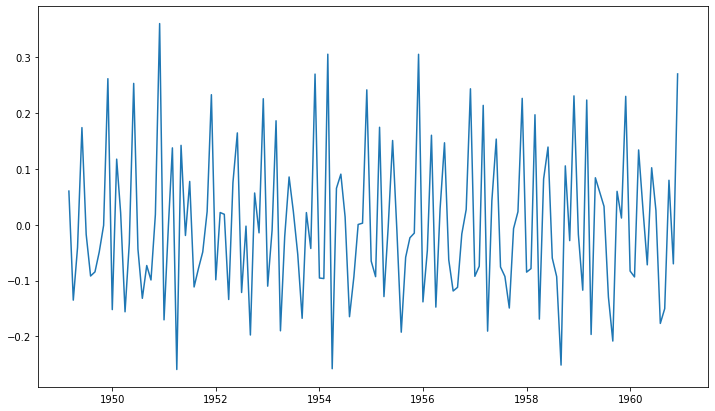

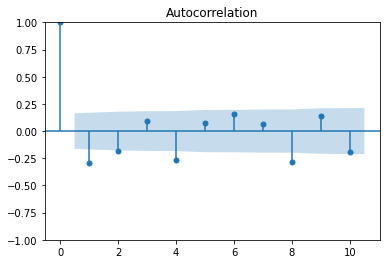

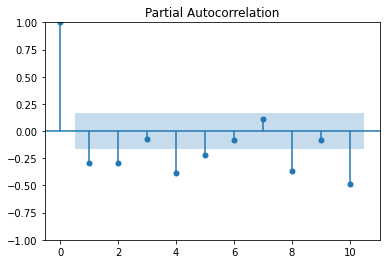

In [24]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(12,7))
plt.plot(Passengersd_o2.index,Passengersd_o2.diff_o2)             # plot series
plot_acf(Passengersd_o2.diff_o2, lags=10)      # plot ACF
plot_pacf(Passengersd_o2.diff_o2, lags=10)     # plot PACF
plt.show();
plt.show();

## 4. parameter estimation


In [25]:
from statsmodels.tsa.arima.model import ARIMA
mod = ARIMA(Passengersd_o2['diff_o2'], order=(3,0,0))
result = mod.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                diff_o2   No. Observations:                  142
Model:                 ARIMA(3, 0, 0)   Log Likelihood                  96.861
Date:                Wed, 22 Mar 2023   AIC                           -183.722
Time:                        08:55:07   BIC                           -168.942
Sample:                    03-01-1949   HQIC                          -177.716
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.007     -0.060      0.952      -0.013       0.012
ar.L1         -0.4131      0.133     -3.106      0.002      -0.674      -0.152
ar.L2         -0.3314      0.141     -2.354      0.0

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [26]:
from statsmodels.tsa.arima.model import ARIMA
mod = ARIMA(Passengers['value'], order=(3,2,0))
result = mod.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  144
Model:                 ARIMA(3, 2, 0)   Log Likelihood                  96.858
Date:                Wed, 22 Mar 2023   AIC                           -185.717
Time:                        08:55:17   BIC                           -173.894
Sample:                    01-01-1949   HQIC                          -180.912
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4129      0.124     -3.318      0.001      -0.657      -0.169
ar.L2         -0.3313      0.130     -2.548      0.011      -0.586      -0.076
ar.L3         -0.0834      0.097     -0.864      0.3

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


## 5. diagnostics

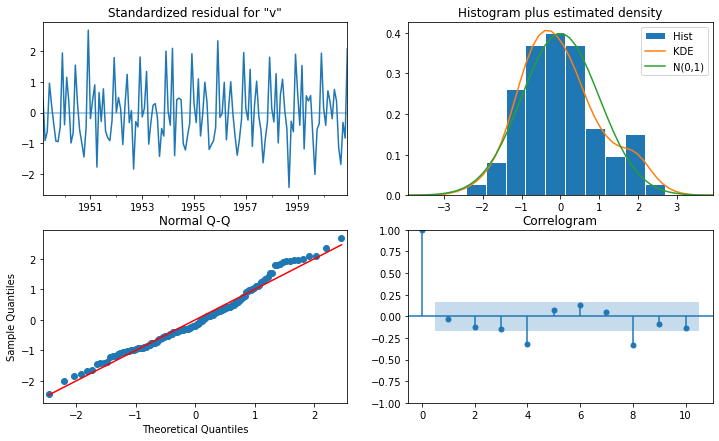

In [27]:
result.plot_diagnostics(figsize=(12,7))
plt.show()

### Ljung-Box test

$\mathrm{H}_{0}$ : The data are independenty distributed (i.e. the correlations in the population from which the sample is taken are 0 , so that any observed correlations in the data result from randomness of the sampling process).

$\mathrm{H}_{\mathrm{a}}$ The data are not independently distributed; they exhibit serial correlation. 

The test statistic is:

$$Q=n(n+2) \sum_{k=1}^{h} \frac{\hat{\rho}_{k}^{2}}{n-k}$$

where $n$ is the sample size, $\hat{\rho}_{k}$ is the sample autocorrelation at lag $k$, and $h$ is the number of lags being tested. Under $H_{0}$ the statistic $Q$ asymptotically follows $\chi_{(h)}^{2}$. 

For significance level a, the critical region for rejection of the hypothesis of randomness is:
$Q>\chi_{1-\alpha, h}^{2}$
where $\chi_{1-\alpha, h}^{2}$ is the $1-$ a-quantile of the chi-squared distribution with $h$ degrees of freedom.

This function returns a test statistic and a corresponding p-value. If the p-value is less than some threshold (e.g. α = .05), you can reject the null hypothesis and conclude that the residuals are not independently distributed.

https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.acorr_ljungbox.html

In [28]:
import statsmodels.api as sm
sm.stats.acorr_ljungbox(result.resid, lags=[10], return_df=True)
#sm.stats.acorr_ljungbox(result.resid, lags=10, return_df=True)
#help(sm.stats.acorr_ljungbox)

,lb_stat,lb_pvalue
10,21.364891,0.018688


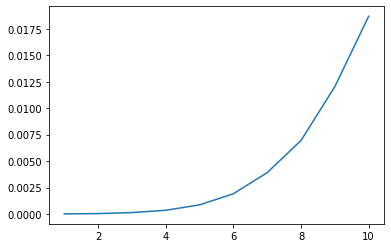

In [29]:
import statsmodels.api as sm
Lj_Box= sm.stats.acorr_ljungbox(result.resid, lags=10,return_df=True)
plt.plot(Lj_Box.index,Lj_Box.lb_pvalue)

##### P-values for first 10 lags are less then $\alpha=0.05$, hence, we reject null hypothesis and conclude that residuals are not independently distributed. 

We can find better model by inspections of AIC's or BIC's of different models and choose the model with the smallest values. 

## 6. model choice

In [31]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 25.0 MB/s eta 0:00:00


In [32]:
from pmdarima import auto_arima
stepwise_fit = auto_arima(Passengers['value'], trace=True,
suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-262.543, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-231.565, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-235.386, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-237.507, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-232.439, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.47 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-269.396, Time=2.24 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-241.608, Time=1.51 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-237.605, Time=1.00 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-268.496, Time=2.59 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-236.952, Time=0.62 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-269.822, Time=3.87 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-275.580, Time=2.24 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-248.753, Time=2.23 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : 

In [33]:
from statsmodels.tsa.arima.model import ARIMA
mod = ARIMA(Passengers['value'], order=(4,1,3))
result = mod.fit()
print(result.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  144
Model:                 ARIMA(4, 1, 3)   Log Likelihood                 149.350
Date:                Wed, 22 Mar 2023   AIC                           -282.700
Time:                        09:08:56   BIC                           -258.998
Sample:                    01-01-1949   HQIC                          -273.069
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1893      0.135      1.403      0.161      -0.075       0.454
ar.L2         -0.3877      0.112     -3.461      0.001      -0.607      -0.168
ar.L3          0.6008      0.111      5.401      0.0

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


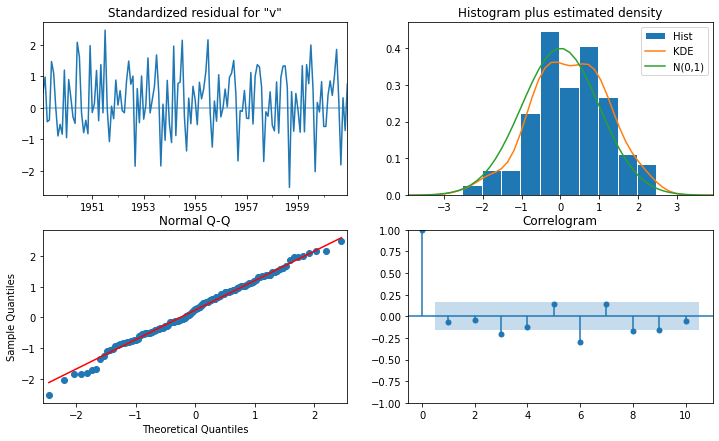

In [34]:
result.plot_diagnostics(figsize=(12,7))
plt.show()

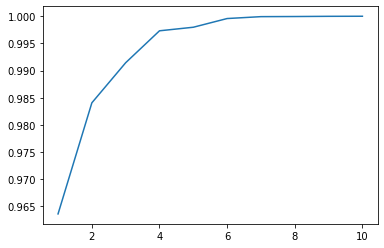

In [35]:
import statsmodels.api as sm
Lj_Box= sm.stats.acorr_ljungbox(result.resid, lags=10,return_df=True)
plt.plot(Lj_Box.index,Lj_Box.lb_pvalue)

##### P-values for first 10 lags are greater then $\alpha=0.05$, hence, we can't reject null hypothesis and conclude that residuals are independently distributed. 

In [36]:
import statsmodels.api as sm
sm.stats.acorr_ljungbox(result.resid, lags=10, return_df=True)
#sm.stats.acorr_ljungbox(result.resid, lags=10, return_df=True)
#help(sm.stats.acorr_ljungbox)

,lb_stat,lb_pvalue
1,0.002080,0.963621
2,0.032135,0.984061
3,0.103301,0.991438
4,0.150377,0.997311
5,0.282102,0.997966
6,0.284924,0.999567
7,0.285194,0.999916
8,0.408985,0.999938
9,0.475652,0.999975
10,0.552847,0.999989
